In [1]:
import sys
sys.path.insert(0, "../../../pymc")

import pymc as pm
import numpy as np
import aesara.tensor as at

from aesara.graph.basic import Variable

import matplotlib.pyplot as plt

In [2]:
N = 100; K = 30
y_obs = np.random.normal(loc=2., scale=2., size=[N],) # fixed

In [3]:
with pm.Model() as model:
    sbw = pm.StickBreakingWeights(name="sbw", alpha=4., K=K)
    atoms = pm.Normal(name="atoms", mu=0., sigma=3., shape=(K,))
    
    indices = at.argsort(atoms)
    undo_indices = at.argsort(indices)
    sorted_atoms = at.sort(atoms)
    
    ecdf = at.sum(
        at.lt(
            y_obs[..., np.newaxis], 
            at.atleast_2d(sorted_atoms),
        ), 
        axis=0
    )
    diff = at.diff(ecdf)
    
    bincounts = at.concatenate(
        [
            [ecdf[0]],
            diff,
        ]
    )[undo_indices]
    
    bincounts = at.concatenate(
        [
            bincounts,
            [N - ecdf[-1]],
        ]
    )
    
    cat = pm.Multinomial(name="mult", n=N, p=sbw, observed=bincounts)

    trace = pm.sample(draws=10000, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sbw, atoms]


Sampling 1 chain for 1_000 tune and 10_000 draw iterations (1_000 + 10_000 draws total) took 248 seconds.
/Users/larryshamalama/Documents/GitHub/pymc3-playground/notebooks/dirichlet-process-brainstorm/../../../pymc/pymc/backends/arviz.py:57: UserWarning: Could not extract data from symbolic observation mult
  warnings.warn(f"Could not extract data from symbolic observation {obs}")
There were 522 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [4]:
sbw_post = trace.to_dict()["posterior"]["sbw"][0][:, :-1]
atoms_post = trace.to_dict()["posterior"]["atoms"][0]

/Users/larryshamalama/anaconda3/envs/pymc3-dev-py38/lib/python3.8/site-packages/arviz/data/inference_data.py:454: UserWarning: The attributes are not same for all groups. Considering only the first group `attrs`
  warnings.warn(


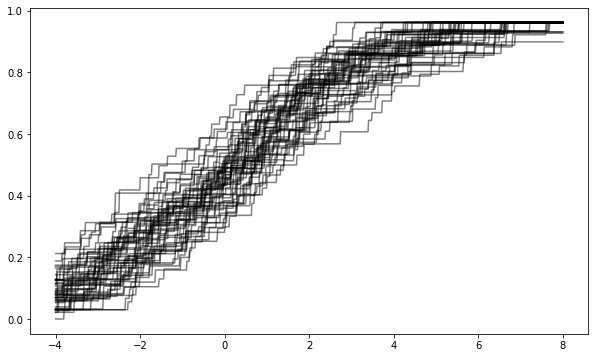

In [5]:
x_plot = np.linspace(-4, 8, num=1001)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))

for draw in range(50):
    dirac = np.less.outer(atoms_post[draw*10], x_plot).astype(int)
    dp_post = (sbw_post[..., np.newaxis]*dirac).sum(axis=1)
    _ = ax.plot(x_plot, dp_post.mean(axis=0), c="k", alpha=0.5)

array([[<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'x'}>]], dtype=object)

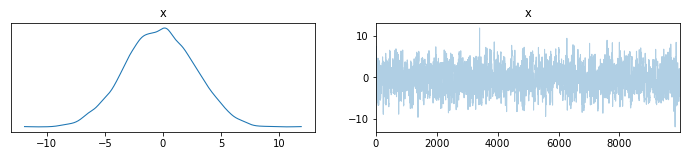

In [6]:
pm.plot_trace(atoms_post[:, 0])

In [ ]:
trace.to_dict()["posterior"]["atoms"][0, :, 0, :]

In [ ]:
import aesara

aesara.dprint(bincounts)

In [ ]:
with pm.Model():
    const = pm.Constant("const", 1)
    prior = pm.sample_prior_predictive()
    step = pm.Metropolis()
    trace = pm.sample(chains=1, step=step)

In [ ]:
isinstance(const, Variable)

### DP class??

In [ ]:
class DirichletProcess:
    def __init__(self, alpha, G0, K, observed=None):
        """
        alpha: concentration parameter
        G0: base distribution
        K: truncation parameter
        """
        self.weights = pm.StickBreakingWeights(name="sbw-weights", alpha=alpha, K=K)
        
        if observed is not None:
#             model = pm.modelcontext(None)
#             model.register_rv(
#                 rv_var=G0,
#                 name="G0",
#                 data=observed
#             )
            Gn_mix_weights = [pm.Constant("Gn-weight-1", 0.3), pm.Constant("Gn-weight-2", 0.7)]
            Gn_components = [G0, pm.DiscreteUniform.dist(lower=0, upper=len(observed))]
            Gn = pm.Mixture("Gn", Gn_mix_weights, Gn_components)

In [ ]:
with pm.Model():
    weights = pm.StickBreakingWeights(name="sbw", alpha=5, K=13)
    G0 = pm.Normal.dist(mu=0, sigma=3)
    prior = pm.sample_prior_predictive()